In [ ]:
import kagglehub

path = kagglehub.dataset_download("swoyam2609/fresh-and-stale-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1


In [ ]:
train_path = '/root/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1/dataset/Train'
test_path = '/root/.cache/kagglehub/datasets/swoyam2609/fresh-and-stale-classification/versions/1/dataset/Test'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os


In [ ]:
import os

train_classes = set(os.listdir(train_path))
test_classes = set(os.listdir(test_path))

common_classes = sorted(train_classes & test_classes)
common_classes

['freshapples',
 'freshbanana',
 'freshcucumber',
 'freshokra',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottencucumber',
 'rottenokra',
 'rottenoranges']

In [ ]:
IMG_SIZE = 300
BATCH_SIZE = 32

# Генератор для тренировочной выборки
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=common_classes,
    shuffle=True
)

# Генератор для тестовой выборки
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    classes=common_classes,
    shuffle=False
)


Found 16023 images belonging to 10 classes.
Found 5490 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# EfficientNetB3 с замороженными слоями
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # замораживаем

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(len(common_classes), activation='softmax')(x)

EfficientNetB3_frozen = Model(inputs=base_model.input, outputs=predictions)
EfficientNetB3_frozen.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

EfficientNetB3_frozen.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 10,798,905 (41.19 MB)

 Trainable params: 15,370 (60.04 KB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [ ]:
history = EfficientNetB3_frozen.fit(
    train_generator,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 190s 278ms/step - accuracy: 0.2208 - loss: 2.0671
Epoch 2/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 147s 231ms/step - accuracy: 0.2510 - loss: 1.9603
Epoch 3/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 131s 262ms/step - accuracy: 0.2592 - loss: 1.9281
Epoch 4/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 115s 229ms/step - accuracy: 0.2656 - loss: 1.9012
Epoch 5/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 117s 234ms/step - accuracy: 0.2784 - loss: 1.8834
Epoch 6/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 118s 235ms/step - accuracy: 0.2731 - loss: 1.8851
Epoch 7/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 116s 232ms/step - accuracy: 0.2762 - loss: 1.8769
Epoch 8/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 146s 240ms/step - accuracy: 0.2841 - loss: 1.8596
Epoch 9/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 119s 238ms/step - accuracy: 0.2848 - loss: 1.8513
Epoch 10/10
501/501 ━━━━━━━━━━━━━━━━━━━━ 120s 239ms/step - accuracy: 0.2776 - loss: 1.8464


5490/5490 ━━━━━━━━━━━━━━━━━━━━ 83s 12ms/step
Classification Report:
                precision    recall  f1-score   support

   freshapples       0.00      0.00      0.00       791
   freshbanana       0.66      0.08      0.13       892
 freshcucumber       0.00      0.00      0.00       279
     freshokra       0.00      0.00      0.00       370
  freshoranges       0.00      0.00      0.00       388
  rottenapples       0.19      0.97      0.32       988
  rottenbanana       0.61      0.28      0.38       900
rottencucumber       0.00      0.00      0.00       255
    rottenokra       0.00      0.00      0.00       224
 rottenoranges       0.00      0.00      0.00       403

      accuracy                           0.23      5490
     macro avg       0.15      0.13      0.08      5490
  weighted avg       0.24      0.23      0.14      5490



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


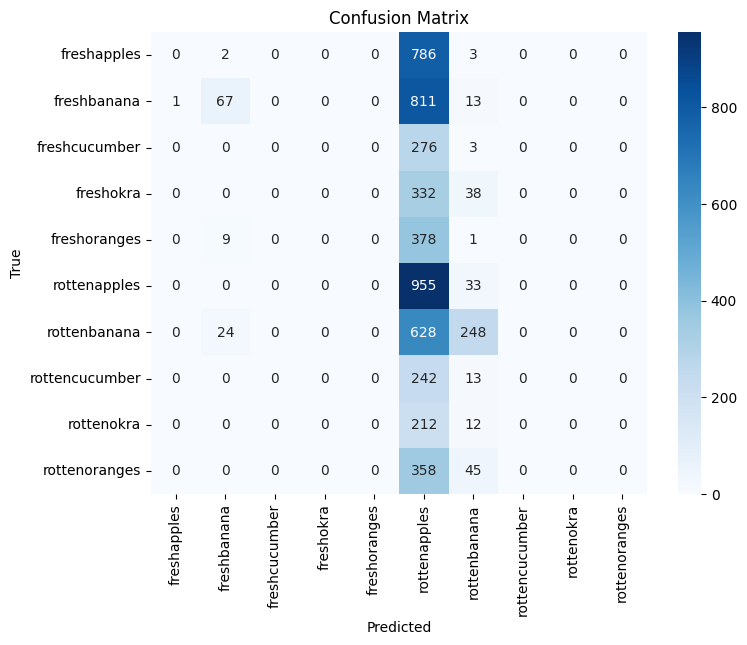

In [ ]:
# Предсказания
Y_pred = EfficientNetB3_frozen.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=common_classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=common_classes, yticklabels=common_classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


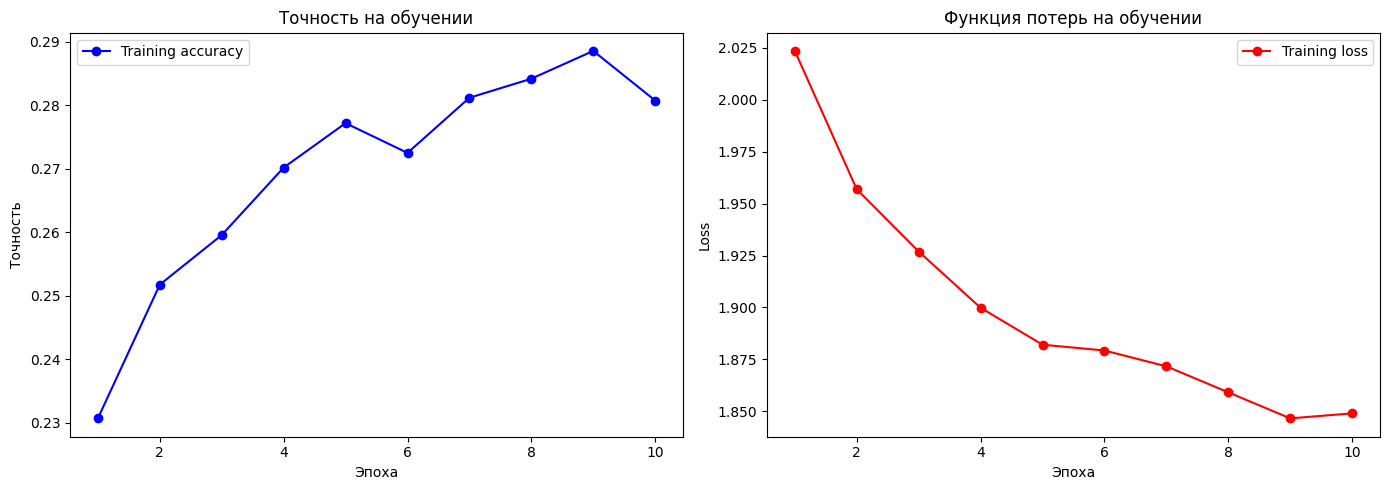

In [ ]:
import matplotlib.pyplot as plt

# Достаем значения из истории обучения
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)

# График точности
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.title('Точность на обучении')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

# График функции потерь
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'ro-', label='Training loss')
plt.title('Функция потерь на обучении')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
EfficientNetB3_frozen.save('efficientnetb3_fresh_stale.h5')


In [ ]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Загружаем базовую модель с предобученными весами
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True  # Размораживаем все слои!

# Создаём "голову" модели
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(len(common_classes), activation='softmax')(x)

# Объединяем в финальную модель
model_non_frozen = Model(inputs=base_model.input, outputs=predictions)

# Компилируем
model_non_frozen.compile(optimizer=Adam(learning_rate=1e-5),  # пониже learning rate, чтобы не испортить веса
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

model_non_frozen.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 300, 300,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 300, 300,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 300, 300,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 10,798,905 (41.19 MB)

 Trainable params: 10,711,602 (40.86 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [ ]:
history_non_frozen = model_non_frozen.fit(
    train_generator,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
  3/501 ━━━━━━━━━━━━━━━━━━━━ 5:04:42 37s/step - accuracy: 0.0694 - loss: 2.4082

In [ ]:
# Предсказания
Y_pred_nf = model_non_frozen.predict(test_generator)
y_pred_nf = np.argmax(Y_pred_nf, axis=1)
y_true_nf = test_generator.classes

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Classification Report (Non-Frozen):")
print(classification_report(y_true_nf, y_pred_nf, target_names=common_classes))

# Матрица ошибок
cm_nf = confusion_matrix(y_true_nf, y_pred_nf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_nf, annot=True, fmt='d', xticklabels=common_classes, yticklabels=common_classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix — Non-Frozen')
plt.show()


In [ ]:
# Динамика обучения модели с размороженными слоями
acc_nf = history_non_frozen.history['accuracy']
loss_nf = history_non_frozen.history['loss']
epochs_nf = range(1, len(acc_nf) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_nf, acc_nf, 'bo-', label='Training Accuracy')
plt.title('Точность — Non-Frozen')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_nf, loss_nf, 'ro-', label='Training Loss')
plt.title('Ошибка — Non-Frozen')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model_non_frozen.save('/content/drive/MyDrive/efficientnetb3_non_frozen.h5')
